In [12]:
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from ultralytics import YOLO
import cv2


In [3]:
with open('data/data.yaml', 'r') as file:
    config = yaml.safe_load(file)
train_path = config['train']
val_path = config['val']
test_path = config['test']
num_classes = config['nc']
class_names = config['names']
print("Train Path:", train_path)
print("Validation Path:", val_path)
print("Test Path:", test_path)
print("Number of Classes:", num_classes)
print("Class Names:", class_names)

Train Path: data/train/images
Validation Path: data/valid/images
Test Path: data/test/images
Number of Classes: 25
Class Names: ['Bed', 'Cabinet', 'Carpet', 'Ceramic floor', 'Chair', 'Closet', 'Cupboard', 'Curtains', 'Dining Table', 'Door', 'Frame', 'Futec frame', 'Futech tiles', 'Gypsum Board', 'Lamp', 'Nightstand', 'Shelf', 'Sideboard', 'Sofa', 'TV stand', 'Table', 'Transparent Closet', 'Wall Panel', 'Window', 'Wooden floor']


In [4]:
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [416, 416])  
    image = image / 255.0 
    return image

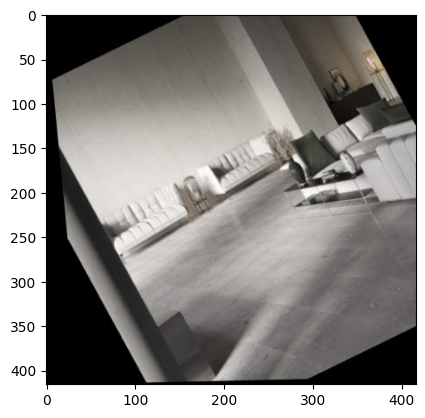

In [5]:
sample_image_path = os.path.join(train_path, os.listdir(train_path)[4])

preprocessed_image = preprocess_image(sample_image_path)
plt.imshow(preprocessed_image)
plt.show()

In [22]:
def load_and_preprocess_data(image_path):
    import os
    image_path = image_path.numpy().decode('utf-8') if isinstance(image_path, tf.Tensor) else image_path
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [416, 416])
    image = image / 255.0
    
    image_dir, image_filename = os.path.split(image_path)
    label_dir = image_dir.replace('images', 'labels')
    label_filename = os.path.splitext(image_filename)[0] + '.txt'
    label_path = os.path.join(label_dir, label_filename)

    class_ids_list = []
    bboxes_list = []
    try:
        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                line = line.strip()
                if line:
                    values = [float(x) for x in line.strip().split()]
                    class_id = int(values[0])
                    coords = values[1:]
                    if len(coords) == 4:
                        x_center, y_center, width, height = coords
                        bbox = [x_center, y_center, width, height]
                        class_ids_list.append(class_id)
                        bboxes_list.append(bbox)
    except Exception as e:
        print(f"Error reading {label_path}: {e}")
        class_ids_list.append(-1)
        bboxes_list.append([0, 0, 0, 0])

    class_ids = np.array(class_ids_list, dtype=np.int32)
    bboxes = np.array(bboxes_list, dtype=np.float32)
    bboxes = bboxes.reshape(-1, 4)
    num_detections = len(class_ids)
    if num_detections > MAX_DETECTIONS:
        class_ids = class_ids[:MAX_DETECTIONS]
        bboxes = bboxes[:MAX_DETECTIONS]
    else:
        pad_amount = MAX_DETECTIONS - num_detections
        class_ids = np.pad(class_ids, (0, pad_amount), 'constant', constant_values=-1)
        bboxes = np.pad(bboxes, ((0, pad_amount), (0, 0)), 'constant', constant_values=0)

    return image, tf.convert_to_tensor(class_ids), tf.convert_to_tensor(bboxes)

In [23]:
def create_dataset(image_dir, batch_size=32):
    image_paths = [
        os.path.join(image_dir, fname)
        for fname in os.listdir(image_dir)
        if fname.endswith(('.jpg', '.png'))
    ]
    if not image_paths:
        raise ValueError(f"No image files found in directory {image_dir}")

    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(lambda x: tf.py_function(
        func=load_and_preprocess_data,
        inp=[x],
        Tout=(tf.float32, tf.int32, tf.float32)
    ), num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.map(lambda image, class_ids, bboxes: (
        tf.ensure_shape(image, [416, 416, 3]),
        {
            'classification': tf.ensure_shape(class_ids, [MAX_DETECTIONS]),
            'bbox': tf.ensure_shape(bboxes, [MAX_DETECTIONS, 4])
        }
    ))

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [24]:
train_dataset = create_dataset(train_path)
val_dataset = create_dataset(val_path)
test_dataset = create_dataset(test_path)

In [6]:
model =  YOLO("yolov8n.pt")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6.25M/6.25M [00:00<00:00, 64.3MB/s]


In [7]:
def detect_objects(image):
    results = model(image)
    annotated_image = results[0].plot()
    return annotated_image

In [9]:
preprocessed_image = preprocess_image(sample_image_path)
# res = detect_objects(preprocessed_image)


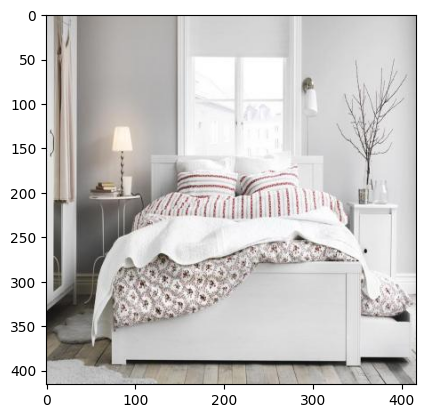

In [24]:
sample_image_path = os.path.join(test_path, os.listdir(test_path)[10])
image = Image.open(sample_image_path)
plt.imshow(image)


0: 640x640 1 potted plant, 1 bed, 1 vase, 76.4ms
Speed: 12.3ms preprocess, 76.4ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)


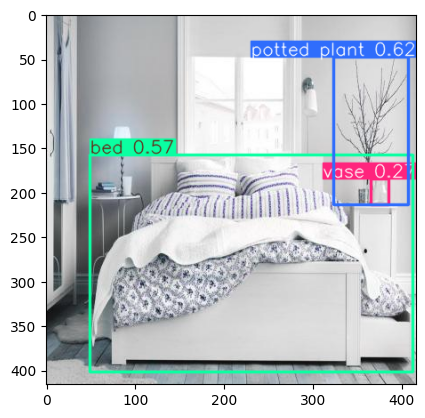

In [25]:
image = Image.open(sample_image_path)
res = detect_objects(image)
plt.imshow(res)
plt.show()


In [25]:
base_model = applications.MobileNetV2(input_shape=(416, 416, 3), include_top=False, weights='imagenet')
base_model.trainable = False

In [26]:
inputs = layers.Input(shape=(416, 416, 3))
# x = data_augmentation(inputs)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)

In [27]:
classification_output = layers.Dense(MAX_DETECTIONS * num_classes, activation='softmax', name='classification')(x)
classification_output = layers.Reshape((MAX_DETECTIONS, num_classes))(classification_output)


In [28]:
bbox_output = layers.Dense(MAX_DETECTIONS * 4, name='bbox')(x)
bbox_output = layers.Reshape((MAX_DETECTIONS, 4))(bbox_output)

In [ ]:
def detection_loss(y_true, y_pred):
    valid_mask = tf.not_equal(y_true, -1)
    y_true_flat = tf.boolean_mask(y_true, valid_mask)
    y_pred_flat = tf.boolean_mask(y_pred, valid_mask)
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true_flat, y_pred_flat))

def bbox_loss(y_true, y_pred):
    valid_mask = tf.reduce_any(tf.not_equal(y_true, 0), axis=-1)
    y_true_valid = tf.boolean_mask(y_true, valid_mask)
    y_pred_valid = tf.boolean_mask(y_pred, valid_mask)
    return tf.reduce_mean(tf.keras.losses.mean_squared_error(y_true_valid, y_pred_valid))


In [29]:
model = tf.keras.Model(
    inputs=inputs, 
    outputs={
        'classification': classification_output,
        'bbox': bbox_output
    }
)

In [30]:
model.compile(
    optimizer='adam',
    loss='mse',
    metrics={
        'classification': 'accuracy'
    }
)

In [31]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset)

Epoch 1/10


ValueError: in user code:

    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/losses.py", line 1706, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 25 and 5 for '{{node mean_squared_error_1/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](model_1/reshape_2/Reshape, mean_squared_error_1/Cast)' with input shapes: [?,5,25], [?,5].
